In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

import joblib

In [3]:
# Turn down for faster convergence
train_samples = 60000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [4]:
# ensures randomized order of the dataset
random_state = check_random_state(0)

#random shuffling X and y
permutation = random_state.permutation(X.index)
X = X.loc[permutation].reset_index(drop=True)
y = y.loc[permutation].reset_index(drop=True)

# Converts input features into a 2D format for logistic regression or SVMs
X = X.values.reshape((X.shape[0], -1))

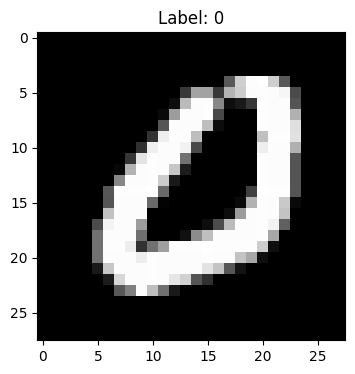

In [36]:
import matplotlib.pyplot as plt

# have a look at the image
image_index = 21  
image = X[image_index].reshape(28, 28)

# Display the image
plt.figure(figsize=(4, 4))
plt.imshow(image, cmap="gray")
plt.title(f"Label: {y[image_index]}")  # Display corresponding label
plt.show()


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

In [7]:
print(X.shape, y.shape)

(70000, 784) (70000,)


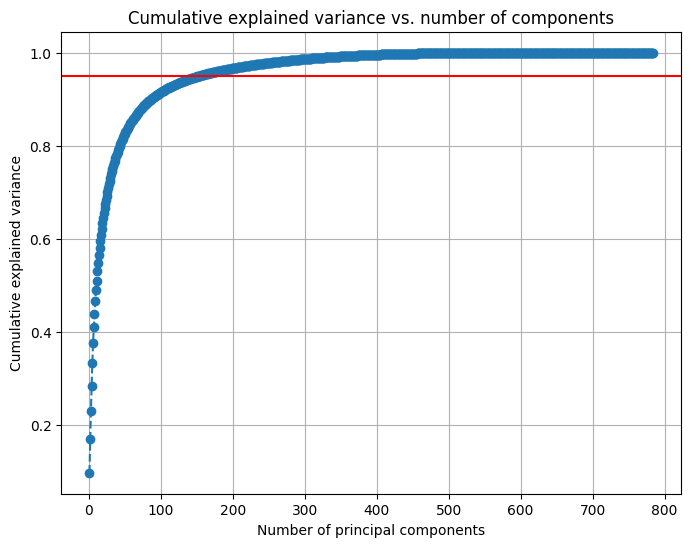

154


In [13]:
from sklearn.decomposition import PCA

# Apply PCA to the training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Compute the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative variance to determine the number of components for 95% threshold
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance")
plt.title("Cumulative explained variance vs. number of components")
plt.grid()
plt.show()

# Determine the number of components needed for 95% variance
num_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Apply PCA with the selected number of components
pca = PCA(n_components=num_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
joblib.dump(pca, "pca_mnist_model.joblib")

print(num_components_95)

In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_pca)
X_test_std = scaler.transform(X_test_pca)

# Save the scaler to a file for further use on new data
joblib.dump(scaler, "scaler_mnist_model.joblib")

['scaler_mnist_model.joblib']

In [10]:

# Create a classifier
clf = svm.SVC(gamma=0.0001)
clf.fit(X_train_std, y_train)

train_score = clf.score(X_train_std, y_train)
score = clf.score(X_test_std, y_test)
print("Train accuracy:%.4f" % train_score)
print("Test accuracy: %.4f" % score)

# Save the trained model to a file
joblib.dump(clf, "svm_mnist_model.joblib")

Train accuracy:0.9156
Test accuracy: 0.9101


['svm_mnist_model.joblib']

In [14]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for GridSearchCV
param_grid = {
    'C': [1, 5, 10],   # Regularization parameter
    'gamma': [0.0001, 0.001, 0.01],  # Kernel coefficient for RBF
    }

# Create an SVM classifier
clf = svm.SVC()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(clf, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_std, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_score = best_model.score(X_train_std, y_train)
test_score = best_model.score(X_test_std, y_test)

# Save the best model
joblib.dump(best_model, "svm_mnist.joblib")

# Output best parameters and scores
best_params, train_score, test_score


Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV] END ...................................C=1, gamma=0.001; total time= 3.1min
[CV] END ...................................C=1, gamma=0.001; total time= 3.1min
[CV] END ...................................C=1, gamma=0.001; total time= 3.1min
[CV] END ....................................C=1, gamma=0.01; total time= 5.3min
[CV] END ....................................C=1, gamma=0.01; total time= 5.4min
[CV] END ..................................C=5, gamma=0.0001; total time= 3.7min
[CV] END ..................................C=5, gamma=0.0001; total time= 3.9min
[CV] END ...................................C=5, gamma=0.001; total time= 1.7min
[CV] END ..................................C=1, gamma=0.0001; total time= 7.8min
[CV] END ..................................C=1, gamma=0.0001; total time= 7.8min
[CV] END ..................................C=1, gamma=0.0001; total time= 7.8min
[CV] END ....................................C=1,

({'C': 5, 'gamma': 0.01}, 1.0, 0.9744)

In [15]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test_std)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.98       964
           1       0.99      0.99      0.99      1092
           2       0.95      0.98      0.96      1020
           3       0.97      0.97      0.97      1022
           4       0.97      0.98      0.98       971
           5       0.96      0.97      0.96       910
           6       0.99      0.97      0.98       970
           7       0.98      0.96      0.97       999
           8       0.96      0.98      0.97      1033
           9       0.98      0.96      0.97      1019

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



<Figure size 800x600 with 0 Axes>

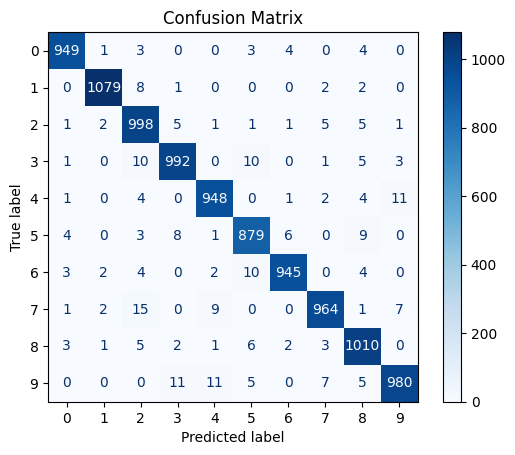

In [16]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict labels for the test set
y_pred = best_model.predict(X_test_std)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()
